# Bedrock Claude 및 LangGraph 를 이용한 Prompt Flow - [Advanced] Tool Node 사용

In [1]:
!python -V

Python 3.10.14


# 0. 환경 설정

In [2]:
%load_ext autoreload
%autoreload 2

import sys, os

def add_python_path(module_path):
    if os.path.abspath(module_path) not in sys.path:
        sys.path.append(os.path.abspath(module_path))
        print(f"python path: {os.path.abspath(module_path)} is added")
    else:
        print(f"python path: {os.path.abspath(module_path)} already exists")
    print("sys.path: ", sys.path)

module_path = "../.."
add_python_path(module_path)

python path: /home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications is added
sys.path:  ['/home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/11_prompt_chaining_with_langgraph/langgraph', '/opt/conda/lib/python310.zip', '/opt/conda/lib/python3.10', '/opt/conda/lib/python3.10/lib-dynload', '', '/home/sagemaker-user/.local/lib/python3.10/site-packages', '/opt/conda/lib/python3.10/site-packages', '/home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications']


In [3]:
# !pip install pydantic>=2.7.0
!pip show pydantic

Name: pydantic
Version: 2.9.1
Summary: Data validation using Python type hints
Home-page: https://github.com/pydantic/pydantic
Author: 
Author-email: Samuel Colvin <s@muelcolvin.com>, Eric Jolibois <em.jolibois@gmail.com>, Hasan Ramezani <hasan.r67@gmail.com>, Adrian Garcia Badaracco <1755071+adriangb@users.noreply.github.com>, Terrence Dorsey <terry@pydantic.dev>, David Montague <david@pydantic.dev>, Serge Matveenko <lig@countzero.co>, Marcelo Trylesinski <marcelotryle@gmail.com>, Sydney Runkle <sydneymarierunkle@gmail.com>, David Hewitt <mail@davidhewitt.io>, Alex Hall <alex.mojaki@gmail.com>
License: 
Location: /opt/conda/lib/python3.10/site-packages
Requires: annotated-types, pydantic-core, typing-extensions
Required-by: amazon_sagemaker_jupyter_scheduler, anthropic, confection, fastapi, gluonts, jupyter_scheduler, langchain, langchain-anthropic, langchain-core, langsmith, sagemaker-core, sagemaker-jupyterlab-extension-common, spacy, thinc, weasel


## 1. Bedrock Client 생성

In [4]:
from pprint import pprint
from termcolor import colored
from utils import bedrock
from utils.bedrock import bedrock_info

boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: us-east-1
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-5-Sonnet': 'anthropic.claude-3-5-sonnet-20240620-v1:0',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Opus': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid-v1',
 'Jurassic-2-Ultra': 'ai21.j2-ultra-v1',
 'Llama2-13b-Chat': 'meta.llama2-13b-chat-v1',
 'Titan-Embeddings-G1': 'amazon.titan-embed-text-v1'

### 모델 ID 및 Bedrock converse API 정의

In [5]:
from utils.bedrock import *

content_model_id="anthropic.claude-3-haiku-20240307-v1:0"
# content_model_id = "anthropic.claude-3-5-sonnet-20240620-v1:0"
img_model_id = "amazon.titan-image-generator-v2:0"


## 2. Tool 정의
- Tool: LangChain에서 주로 사용되는 개념으로, 에이전트가 특정 작업을 수행하기 위해 호출할 수 있는 유틸리티 함수. 즉, LangChain에서 LLM이 외부 시스템과 상호작용할 수 있도록 하는 개념
Langgrpah에서는 Tool Node를 통해 통합될 수 있음
(ex) 간단한 수학 연산 함수, 외부 DB 쿼리하는 함수

In [6]:
from typing import Annotated
from langchain_core.tools import tool
from utils.cross_region_inference_prompt_util import *
from jinja2 import Template
from langchain_core.agents import AgentFinish
from langgraph.prebuilt import ToolNode

@tool
def create_outline_prompt(
    topic: Annotated[str, "프레젠테이션의 토픽"]
    ):
    """설정한 주제로 프레젠테이션의 개요를 만드는 프롬프트를 만드는 tool"""
    try:
        # 프롬프트 템플릿 파일의 경로를 지정
        prompt_folder = "prompt_template"
        outline_prompt_file_name = "outline_prompt_template.txt"
        
        outline_prompt_file_path = os.path.join(prompt_folder, outline_prompt_file_name)
        outline_template_content = load_template_from_file(outline_prompt_file_path)
        OUTLINE_PROMPT_TEMPLATE = Template(outline_template_content)
        outline_prompt = OUTLINE_PROMPT_TEMPLATE.render(topic=topic)

        return outline_prompt
    except Exception as e:
        return f"An error occurred: {str(e)}"


@tool
def create_img_prompt(
    topic: Annotated[str, "프레젠테이션의 개요"]
    ):
    """설정한 주제로 프레젠테이션의 대표 이미지를 만드는 프롬프트를 만드는 tool"""
    try:
        # 프롬프트 템플릿 파일의 경로를 지정
        prompt_folder = "prompt_template"
        img_prompt_file_name = "img_prompt_template.txt"
        
        img_prompt_file_path = os.path.join(prompt_folder, img_prompt_file_name)
        img_template_content = load_template_from_file(img_prompt_file_path)
        IMG_PROMPT_TEMPLATE = Template(img_template_content)
        img_prompt = IMG_PROMPT_TEMPLATE.render(topic=topic)

        return img_prompt
    except Exception as e:
        return f"An error occurred: {str(e)}"

## 3. Langgrpah 구축

### 그래프 정의
- State 정의
- 그래프 빌더 정의
- 노드, 에지 정의
- 그래프 컴파일

### 1. State 정의

In [7]:
import operator
from typing import TypedDict, Annotated, Any, Sequence, Union
from langgraph.graph import StateGraph, START, END
from langchain_anthropic import ChatAnthropic
from langchain_core.agents import AgentAction, AgentFinish

# This defines the object that is passed between each node in the graph. We will create different nodes for each agent and tool
class State(TypedDict):
    topic: Annotated[str, "프레젠테이션 주제"]
    outline_prompt: Annotated[str, "프레젠테이션 개요 생성을 위해 실행할 프롬프트"]
    img_prompt: Annotated[str, "프레젠테이션 주제를 대표하는 이미지 생성을 위해 실행할 프롬프트"]
    outline: Annotated[str, "프레젠테이션 개요"]
    slide_prompt_1: Annotated[str, "슬라이드 내용 생성을 위해 실행할 프롬프트(배치1)"]
    slide_prompt_2: Annotated[str, "슬라이드 내용 생성을 위해 실행할 프롬프트(배치2)"]
    slide_content_1: Annotated[str, "slide_prompt_1로 만들어진 프레젠테이션 내용"]
    slide_content_2: Annotated[str, "slide_prompt_2로 만들어진 프레젠테이션 내용"]
    completed_content: Annotated[str, "최종 생성된 프레젠테이션 내용"]
    img_path: Annotated[str, "생성된 대표 이미지"]

### 2. Tool Nodes 정의

In [8]:
from langgraph.prebuilt import ToolNode
from langchain.tools import Tool
from langchain_core.tools import StructuredTool

tools = [create_outline_prompt, create_img_prompt]

tool_node = ToolNode(tools)

### 3. Agent Nodes 정의

In [9]:
import functools
from langchain.prompts import PromptTemplate
from langchain_core.messages import AIMessage
from langchain_core.agents import AgentFinish
from langgraph.prebuilt.tool_executor import ToolExecutor
import json
import boto3
import base64
import random


# # 템플릿 파일 기술
from utils.cross_region_inference_prompt_util import *
from jinja2 import Template

# 템플릿 파일의 경로를 지정
prompt_folder = "prompt_template"
outline_prompt_file_name = "outline_prompt_template.txt"
prompt_file_path = os.path.join(prompt_folder, outline_prompt_file_name)
template_content = load_template_from_file(prompt_file_path)
PROMPT_TEMPLATE = Template(template_content)

# Tool to create outline prompt
def create_outline_prompt_agent(state:State)-> State:
    topic = state["topic"]

    message_with_single_tool_call = AIMessage(
        content="",
        tool_calls=[
            {
                "name": "create_outline_prompt",
                "args": {"topic":topic},
                "id": "tool_call_id",
                "type": "tool_call",
            }
        ],
    )

    output = tool_node.invoke({"messages":[message_with_single_tool_call]})
    outline_prompt = output['messages'][0].content
    print("\n## Generated Prompt for outline prompt")
    print(outline_prompt)
    return State(outline_prompt=outline_prompt)


# Define the outline generation agent node
def generate_outline(state:State) -> State:
    outline_prompt = state["outline_prompt"]
    response = converse_invoke(boto3_bedrock, content_model_id, outline_prompt)
    
    outline = response['output']['message']['content'][0]['text']
    print("\n## Generated outline")
    print("response: \n", outline)
    return State(outline=outline)


# Create slide content generation prompt (ppt 1-5)
def create_slide_prompt1(state: State) -> State:
    # 슬라이드 내용 생성 prompt template 로딩
    prompt_file_name = "slide_prompt_template.txt"
    slide_prompt_file_path = os.path.join(prompt_folder, prompt_file_name)
    template_content = load_template_from_file(slide_prompt_file_path)
    slide_prompt_template = Template(template_content)
    
    topic = state["topic"]
    outline = state["outline"]

    slide_prompt_1 = slide_prompt_template.render(
        topic = topic,
        outline = outline,
        start_slide = 1,
        end_slide = 5
    )
    print("\n## Generated Prompt for slides 1-5...")
    print(slide_prompt_1)
    return State(slide_prompt_1=slide_prompt_1)


# Create slide content generation prompt (ppt 6-10)
def create_slide_prompt2(state: State) -> State:
    # 슬라이드 내용 생성 prompt template 로딩
    prompt_file_name = "slide_prompt_template.txt"
    slide_prompt_file_path = os.path.join(prompt_folder, prompt_file_name)
    template_content = load_template_from_file(slide_prompt_file_path)
    slide_prompt_template = Template(template_content)
    
    topic = state["topic"]
    outline = state["outline"]

    slide_prompt_2 = slide_prompt_template.render(
        topic = topic,
        outline = outline,
        start_slide = 6,
        end_slide = 10
    )
    print("\n## Generated Prompt for slides 6-10...")
    print(slide_prompt_2)
    return State(slide_prompt_2=slide_prompt_2)


# Generate slide content (ppt 1-5)
def generate_slides_phase1(state:State) -> State:
    slide_prompt_1 = state["slide_prompt_1"]
    
    response1 = converse_invoke(boto3_bedrock, content_model_id, slide_prompt_1)
    # response1 = converse_invoke_with_backoff(boto3_bedrock, content_model_id, slide_prompt1)
    
    output_message1 = response1['output']['message']['content'][0]['text']
    print("\n## Generated content for slides 1-5...") 
    print(output_message1)
    return State(slide_content_1=output_message1)


# Generate slide content (ppt 6-10)
def generate_slides_phase2(state:State) -> State:
    slide_prompt_2 = state["slide_prompt_2"]
 
    response2 = converse_invoke(boto3_bedrock, content_model_id, slide_prompt_2)
    # response2 = converse_invoke_with_backoff(boto3_bedrock, content_model_id, slide_prompt2)

    output_message2 = response2['output']['message']['content'][0]['text']
    print("\n## Generated content for slides 6-10...") 
    print(output_message2)
    return State(slide_content_2=output_message2)


# Tool to create image prompt
def create_image_prompt_agent(state:State)-> State:
    topic = state["topic"]
    
    message_with_single_tool_call = AIMessage(
        content="",
        tool_calls=[
            {
            "name": "create_img_prompt",
            "args": {"topic": topic},
            "id": "tool_call_id",
            "type": "tool_call",
            }
        ],
    )
    
    output = tool_node.invoke({"messages":[message_with_single_tool_call]})
    img_prompt = output['messages'][0].content
    print("\n## Generated Prompt for image prompt")
    print(img_prompt)
    return State(img_prompt=img_prompt)


# Define the image generation agent node
def image_generator(state: State) -> State:
    img_prompt = state["img_prompt"]
    # Generate a random seed.
    seed = random.randint(0, 2147483647)

    # Prepare the request
    native_request = {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {"text": img_prompt},
        "imageGenerationConfig": {
            "numberOfImages": 1,
            "quality": "standard",
            "cfgScale": 8.0,
            "height": 512,
            "width": 512,
            "seed": seed,
        },
    }

    try:
        # Invoke the model with the request.
        response = boto3_bedrock.invoke_model(modelId=img_model_id, body=json.dumps(native_request))

        # Decode the response body.
        model_response = json.loads(response["body"].read())

        # Extract the image data.
        base64_image_data = model_response["images"][0]

        # Save the generated image to a local folder.
        i, output_dir = 1, "img_output"
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        while os.path.exists(os.path.join(output_dir, f"titan_{i}.png")):
            i += 1

        image_data = base64.b64decode(base64_image_data)

        image_path = os.path.join(output_dir, f"titan_{i}.png")
        with open(image_path, "wb") as file:
            file.write(image_data)

        print(f"The generated image has been saved to {image_path}")

    except ClientError as e:
        print(f"An error occurred: {e}")
        image_path = None

    return State(img_path=image_path)


def completed_slides(state:State) -> State:
    # slide_content_1=state["slide_content_1"]
    slide_content_1 = state.get("slide_content_1","Content for slides 1-5 not available")
    # slide_content_2=state["slide_content_2"]
    slide_content_2 = state.get("slide_content_2","Content for slides 6-10 not available")
    img_path=state["img_path"]
    img_path = state.get("img_path","Image path not available")

    completed_content = slide_content_1 + slide_content_2

    print("\n## Completed Powerpoint slides...")
    print("\n### Slide contents...")
    print(completed_content)
    print("\n### Image...")
    print(img_path)
    
    return State(completed_content=completed_content)

# Conditional function to check if all required nodes are completed
def all_tasks_completed(state):
    return (
        "slide_content_1" in state
        and "slide_content_2" in state
        and "img_path" in state
    )

### 4. 그래프 생성 및 정의 (노드 추가, 엣지 정의), 그래프 컴파일

In [10]:
graph_builder = StateGraph(State)

graph_builder.add_node("create_outline_prompt_agent", create_outline_prompt_agent)
graph_builder.add_node("generate_outline", generate_outline)
graph_builder.add_node("create_slide_prompt1",create_slide_prompt1)
graph_builder.add_node("create_slide_prompt2",create_slide_prompt2)
graph_builder.add_node("generate_slides_phase1", generate_slides_phase1)
graph_builder.add_node("generate_slides_phase2", generate_slides_phase2)
graph_builder.add_node("create_image_prompt_agent", create_image_prompt_agent)
graph_builder.add_node("image_generator", image_generator)
graph_builder.add_node("completed_slides", completed_slides)

graph_builder.add_edge(START,"create_outline_prompt_agent")
graph_builder.add_edge(START,"create_image_prompt_agent")

graph_builder.add_edge("create_outline_prompt_agent","generate_outline")
graph_builder.add_edge("generate_outline","create_slide_prompt1")
graph_builder.add_edge("generate_outline","create_slide_prompt2")

graph_builder.add_edge("create_slide_prompt1","generate_slides_phase1")
graph_builder.add_edge("create_slide_prompt2","generate_slides_phase2")

graph_builder.add_edge("generate_slides_phase1","completed_slides")
graph_builder.add_edge("generate_slides_phase2","completed_slides")

graph_builder.add_edge("create_image_prompt_agent","image_generator")

graph_builder.add_edge("image_generator","completed_slides")


# graph_builder.add_conditional_edges(
#     "generate_slides_phase1",
#     all_tasks_completed,
#     {
#         True: "completed_slides",
#         False: "generate_slides_phase2"
#     }
# )

# graph_builder.add_conditional_edges(
#     "generate_slides_phase2",
#     all_tasks_completed,
#     {
#         True: "completed_slides",
#         False: "image_generator"
#     }
# )

# graph_builder.add_conditional_edges(
#     "image_generator",
#     all_tasks_completed,
#     {
#         True: "completed_slides",
#         False: END
#     }
# )

graph_builder.add_edge("completed_slides", END)

# 그래프 컴파일
graph = graph_builder.compile()

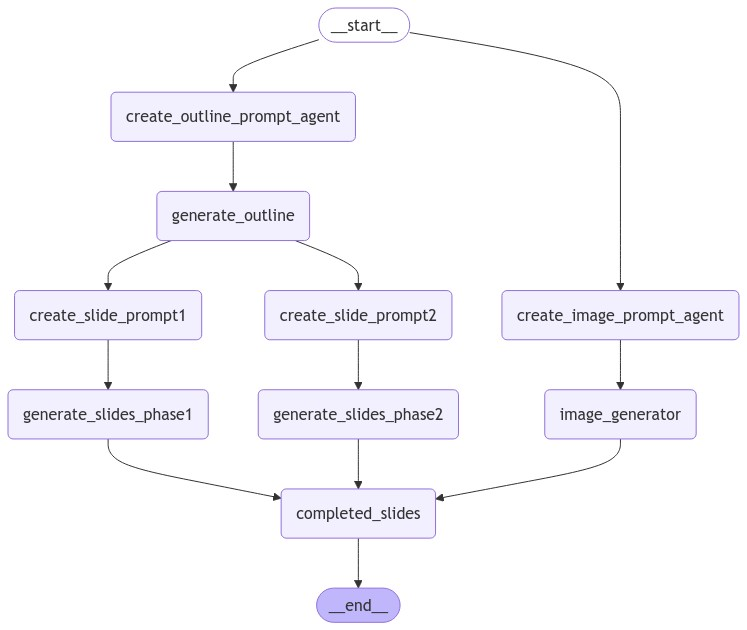

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## 4. Langgraph 실행

### 그래프를 실행할 함수 정의

In [12]:
def run_prompt(topic: str):
    result = graph.invoke(State(topic=topic))
    return result["completed_content"]

In [13]:
TOPIC = "Korea traditional holidays"

### 그래프 실행

In [14]:
run_prompt(TOPIC)


## Generated Prompt for outline prompt
You are an expert in creating impactful and professional PowerPoint presentations. 
Create a detailed outline for a 10-slide presentation in Korean, ensuring a logical flow and comprehensive coverage of the topic.

Analyze the given topic thoroughly to write in the provided <output_format> JSON format.
Return only the JSON object without additional tags or explanations.

<context>
Korea traditional holidays
</context>

<instruction>
1. Title:
   - Create a compelling and concise main title that captures the essence of the presentation.

2. Slides:
   - Generate 10 slides, including an opening and a closing slide.
   - For each slide:
     - Assign a slide_number (01 to 10).
     - Create a clear and informative slide_title.
     
3. Content Guidelines:
   - Ensure a logical flow and structure throughout the presentation.
   - Include an introduction slide (slide 02) and a conclusion slide (slide 09).   

4. Common Points:
   - Include the most im

'안녕하세요. 한국 전통 명절에 대한 세부 내용을 제공해드리겠습니다.\n\n슬라이드 1: 한국 전통 명절 소개\n- 한국의 전통적인 명절은 농경사회와 깊은 관련이 있음\n- 명절은 가족 및 친척들이 모여 함께 시간을 보내며 전통 문화를 공유하는 중요한 시기\n- 대표적인 명절로는 설날, 한가위, 단오, 한식, 대보름 등이 있음\n- 각 명절마다 고유한 풍습과 전통이 존재\n- 최근 현대화와 서구화로 인해 일부 전통이 약화되고 있어 보존이 필요한 상황\n\n데이터 및 예시:\n- 한국 국민 중 62%가 명절에 가족과 함께 시간을 보내는 것으로 조사됨\n- 가정에서 명절 음식을 직접 만드는 비율은 약 70%\n\n시각자료 제안:\n- 가족들이 모여 명절을 보내는 모습의 이미지\n- 명절 음식을 만드는 모습의 이미지\n\n발표자 노트:\n한국의 전통 명절은 오랜 역사와 문화적 의미를 지니고 있으며, 현대에도 많은 사람들이 명절을 중요하게 여기고 있음을 강조하고자 합니다.\n\n슬라이드 2: 명절의 의미와 역사\n- 한국 전통 명절은 농경문화와 유교 사상이 융합된 결과물\n- 음력 기준으로 정해지는 명절은 농작물 수확과 밀접한 연관이 있음\n- 설날, 한가위, 단오 등은 오래전부터 이어져온 전통 명절\n- 명절에는 가족 간의 화합, 조상에 대한 추모, 자연에 대한 감사 등의 의미 내포\n- 현대에도 전통 명절이 지속되면서 문화적 정체성 유지에 기여\n\n데이터 및 예시:\n- 고대부터 현대까지 이어져온 주요 명절의 역사와 의미 소개\n- 명절 풍속이나 전통 음식 등을 통해 표현되는 가치관 및 철학 설명\n\n시각자료 제안:\n- 연대기로 표현된 주요 명절의 역사 정보 그래프\n- 전통 명절의 의미를 상징하는 이미지\n\n발표자 노트:\n한국 전통 명절은 오랜 세월에 걸쳐 형성된 농경문화와 유교 사상이 결합된 결과물로서, 가족 간 화합, 조상 추모, 자연 공경 등의 핵심 가치를 지니고 있음을 설명하고자 합니다.\n\n슬라이드 3: 설날(Seollal, 음력 1월 1일)